In [1]:
from visual_transformer import *

In [2]:
device = torch.device('cuda:1') # the big machine

In [3]:
brain = DefaultAgentBrain().to(device)

In [4]:
from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings)

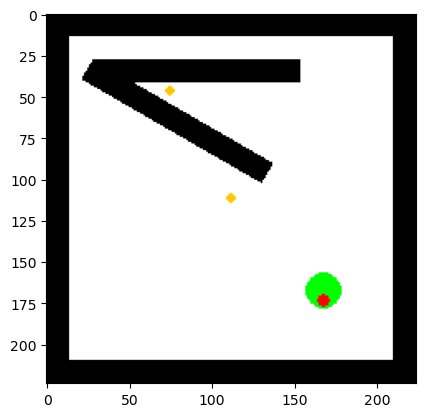

In [6]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [7]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [8]:
criterion = nn.MSELoss()

In [9]:
optimizer = optim.Adam(brain.parameters(), lr=0.001, eps=1e-9) #0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
import time

total_batches = 6250*32

total_loss = 0
brain.train()
for b in range(total_batches):
    if b == 0:
        start = time.time()
    img_set = G.random_full_image_set(restrict_angles=True)
    img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))
    batch_size = img_tensor.size()[0]
    text_context = torch.randn((batch_size, 32, 768), device=device) # easier for pretraining to use randn
    recon = brain.img_autoencoder(img_tensor, text_context)
    loss = criterion(recon, img_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
    if b == 0:
        runtime = time.time() - start
        print(f"Time for 1 batch: {runtime} seconds")
    if (b % 100 == 99):
        avg_loss = total_loss / 100
        total_loss = 0
        print(f"Avg loss for last 100 batches, at batch {b + 1}: {avg_loss}")
        torch.save(brain.img_enc.state_dict(), 'brain_checkpoints/img_encoder_weights_v4.pth')
        torch.save(brain.img_dec.state_dict(), 'brain_checkpoints/img_decoder_weights_v4.pth')

/home/atbolsh/anaconda3/envs/player/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Time for 1 batch: 4.509489297866821 seconds
Avg loss for last 100 batches, at batch 100: 0.26546456083655356
Avg loss for last 100 batches, at batch 200: 0.22070401921868324
Avg loss for last 100 batches, at batch 300: 0.2025985077023506
Avg loss for last 100 batches, at batch 400: 0.19914779871702193
Avg loss for last 100 batches, at batch 500: 0.19863803684711456
Avg loss for last 100 batches, at batch 600: 0.19796324834227563
Avg loss for last 100 batches, at batch 700: 0.19667364433407783
Avg loss for last 100 batches, at batch 800: 0.19923265919089317
Avg loss for last 100 batches, at batch 900: 0.19896750181913375
Avg loss for last 100 batches, at batch 1000: 0.20102986037731171
Avg loss for last 100 batches, at batch 1100: 0.19929137498140334
Avg loss for last 100 batches, at batch 1200: 0.20147166877985
Avg loss for last 100 batches, at batch 1300: 0.19933137014508248
Avg loss for last 100 batches, at batch 1400: 0.1990885154902935
Avg loss for last 100 batches, at batch 1500: 

In [ ]:
# 17 gigs for this. Nice and easy. I probably have enough left over to also run text training on the same device! 
# But there's no reason to push it.

In [ ]:
# I'll kill it after just one day and check on the results. If I like what I see, I'll keep it. Otherwise, I'll either
# let it continue or tweak some things and restart this.

In [ ]:
recon[0]

In [ ]:
quick_display(recon[27])

In [ ]:
quick_display(img_tensor[27])

In [ ]:
 # It almost looks like it can't tell where anything is.

In [ ]:
a = torch.randn((1, 256, 768), device=device)

In [ ]:
b = brain.img_enc.embed[1](a)

In [ ]:
a

In [ ]:
b

In [ ]:
c = b - a * math.sqrt(768)
c

In [ ]:
torch.mean(c)

In [ ]:
math.sqrt(768)

In [ ]:
23200 * 40